In [81]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [82]:
train_data = pd.read_csv('Desktop/d2l-zh/pytorch/data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('Desktop/d2l-zh/pytorch/data/kaggle_house_pred_test.csv')

In [83]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [84]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])    #显示前四个和最后两个特征

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [85]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))  #舍弃第一列id，并连接训练和测试的特征，获取全部特征

In [86]:
#标准化数据
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index     #获取所有数值类型的特征的索引，并存入numeric_features
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))                          #将所有数值特征计算（x-x均值）除标准差，进行标准化
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)  #用0填充数值特征中的缺失值

In [87]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)    #进行二进制编码，比如（1，0，1）这样会使得权重数量增加，可以避免机器认为特征之间存在有序关系
all_features.shape

(2919, 330)

In [88]:
n_train = train_data.shape[0]                 #获取训练数据的行数
train_features = torch.tensor(all_features[:n_train].values.astype(float), dtype=torch.float32) #将数据变为张量形式
test_features = torch.tensor(all_features[n_train:].values.astype(float), dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.astype(float).reshape(-1, 1), dtype=torch.float32)    #将标签转化为张量形式

In [89]:
loss = nn.MSELoss()           #均方误差损失函数 
in_features = train_features.shape[1]       #获取特征维数

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [90]:
def log_rmse(net, features, labels):                            #对数均方根误差
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [91]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []         #每个周期存储对数均方根误差
    train_iter = d2l.load_array((train_features, train_labels), batch_size)              #加载特征，生成一个数据迭代器，每次迭代batch_size个数据
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()     #梯度清零,避免梯度累积
            l = loss(net(X), y)
            l.backward()
            optimizer.step()        #根据梯度更新参数
        train_ls.append(log_rmse(net, train_features, train_labels))    #记录对数均方根误差
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [92]:
def get_k_fold_data(k, i, X, y):        #生成k折交叉验证的训练集和验证集
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [93]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0        #初始化对数均方误差和
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)  #获得当前折的训练和验证数据
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)     #利用当前折的训练和验证数据进行训练
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        # 打印权重
       # print(f'Fold {i + 1} 权重：{list(net.parameters())[0].data}')
        
        if i == 0:                 #在第一个折上绘制训练和验证集均方误差图像
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '   #打印每个折上的均方误差
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.148270, 验证log rmse0.147111
折2，训练log rmse0.145209, 验证log rmse0.161848
折3，训练log rmse0.143806, 验证log rmse0.149245
折4，训练log rmse0.148028, 验证log rmse0.147094
折5，训练log rmse0.143511, 验证log rmse0.174343
5-折验证: 平均训练log rmse: 0.145765, 平均验证log rmse: 0.155928


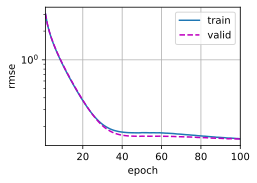

In [94]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [95]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化并保存到submission.csv
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.139911


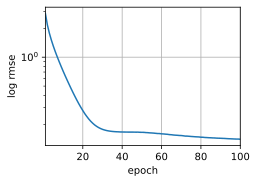

In [96]:
train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size)

In [ ]:
# 假设 net 是你训练好的模型
#net = get_net()

# 假设 test_features 是你要进行预测的特征数据，是一个 PyTorch 的张量
# 注意：在进行预测之前，确保你的模型是处于 evaluation 模式
#net.eval()

# 使用模型进行预测
#predictions = net(test_features)

# 将 PyTorch 张量转换为 NumPy 数组（如果需要）
#predictions_array = predictions.detach().numpy()